In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gensim
import spacy
import nltk

from sentimentpl.models import SentimentPLModel
import matplotlib.pyplot as plt

import re
import unicodedata

from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append('..')

from helpers.dataset import (
    tokenize,
    filter_stop_words,
    deal_with_polish_sign,
    clean_text,
    get_stylometric_features
)

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
stopwords = nlp_core.Defaults.stop_words

# Read data & clean text

In [2]:
df = pd.read_csv('../datasets/demagog_nlp_cz/converted-exp-PL.tsv', sep='\t')

df['text_clean'] = df['statementText'].apply(lambda x: clean_text(x))
df['text_clean'] = df['text_clean'].apply(lambda x: deal_with_polish_sign(x))

# Filter not TRUE/FALSE cases

In [3]:
df['statementState'].value_counts()

statementState
TRUE            1761
FALSE            648
MISLEADING       313
UNVERIFIABLE     113
Name: count, dtype: int64

In [4]:
df = df[ df['statementState'] != 'MISLEADING' ]
df = df[ df['statementState'] != 'UNVERIFIABLE' ]

df = df.reset_index(drop=True)

df['assestment'] = df['statementState'].replace({
    'FALSE' : 1,
    'TRUE' : 0
}).astype(int)

In [5]:
df['words'] = df['text_clean'].progress_apply(
    lambda x: tokenize(x, nlp_core, stopwords, join_str=None)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2409/2409 [00:17<00:00, 140.46it/s]


# Look for more stopwords

In [6]:
df_one = df.copy()

df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

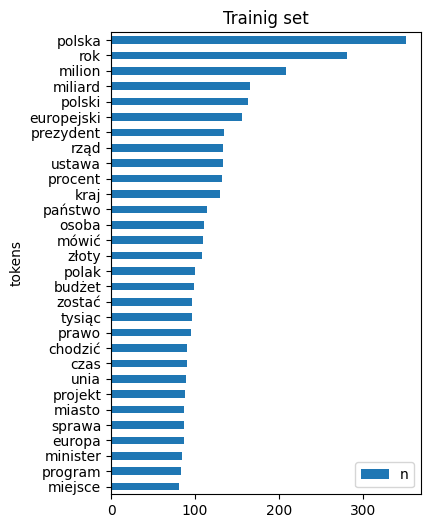

In [7]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(4,6));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

In [8]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'milion',]
                        # 'miliard',] 
                        # 'polski', 'europejski', 
                        # 'prezydent', 'rząd', 'ustawa', 'procent', 'kraj'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [9]:
len(extra_stop_words)

5555

In [10]:
df['words_clean'] = df['words'].progress_apply(
    lambda x: filter_stop_words(x, extra_stop_words, ' ')
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2409/2409 [00:00<00:00, 389983.34it/s]


## Delete rows without  any words

In [11]:
(df['words_clean'].str.len() == 0).sum()

15

In [12]:
df = df[df['words_clean'].str.len() > 0].reset_index(drop=True)

# Stylommetric features

In [13]:
df = get_stylometric_features(df,  nlp_core, model_sent, stopwords, 'words_clean', rerun_all=True)

## Get lexical features ##


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:00<00:00, 58408.40it/s]


## Vocab richness ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:11<00:00, 201.31it/s]


## Readability ##


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:00<00:00, 63882.81it/s]


## Add Sentiment ##


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [03:10<00:00, 12.57it/s]


## Extra features ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:12<00:00, 192.94it/s]


## Add WORDS ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:12<00:00, 193.00it/s]


## Add POS ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:12<00:00, 185.46it/s]


In [14]:
df.columns

Index(['politicianID', 'name', 'party', 'statementID', 'statementText',
       'statementState', 'statementExplanClean', 'statementExplan',
       'text_clean', 'assestment', 'words', 'words_clean', 'avg_word_len',
       'n_words', 'n_unique_words', 'p_unique_words', 'n_char',
       'n_special_char', 'avg_n_vowels_per_word', 'hapax_legomena',
       'hapax_dislegemena', 'honore_r', 'sichel_s', 'brunet_w', 'yule_k',
       'shannon_entropy', 'simpson_idx_d', 'type_token_ratio', 'FR_score',
       'FKG_level', 'Gunning_Fog_index', 'sentiment_all', 'sentiment_avg',
       'n_stop_words', 'n_ent', 'p_adj', 'n_adj', 'p_adv', 'n_adv', 'p_noun',
       'n_noun', 'TEXT_WORD', 'TEXT_POS'],
      dtype='object')

In [15]:
df.shape

(2394, 43)

## Save stylommetric features

In [26]:
target_column = ['assestment']

stylo_features = [
    'avg_word_len',
    'n_words', 'n_unique_words', 'p_unique_words', 'n_char',
    'n_special_char', 'avg_n_vowels_per_word', 'hapax_legomena',
    'hapax_dislegemena', 'honore_r', 'sichel_s', 'brunet_w', 'yule_k',
    'shannon_entropy', 'simpson_idx_d', 'type_token_ratio', 'FR_score',
    'FKG_level', 'Gunning_Fog_index', 'sentiment_all', 'sentiment_avg',
    'n_stop_words', 'n_ent', 'p_adj', 'n_adj', 'p_adv', 'n_adv', 'p_noun',
    'n_noun',
]

cols_for_other_f = ['text_clean', 'TEXT_WORD', 'TEXT_POS']

In [27]:
len(stylo_features)

29

In [28]:
df[target_column+stylo_features].to_parquet('../datasets/used_data/02_classical_ml/02_01_benchmark_styllometric_features.parquet')

# Ngrams POS

In [18]:
n_grams = 5
min_pos = 5 

In [19]:
df_pos = df[target_column].copy()

words =  sum(df['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_POS'].str.count(' '.join(n)) / df['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_pos = pd.concat( [df_pos] + list( col.values() ), axis=1 )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:03<00:00, 316.82it/s]


In [20]:
df_pos.shape

(2394, 1170)

In [21]:
df_pos.to_parquet('../datasets/used_data/02_classical_ml/02_02_benchmark_POS_ngrams.parquet')

# Ngram words

In [22]:
df_ngram = df[target_column + ['TEXT_WORD']].copy()

words =  sum(df['TEXT_WORD'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()

col = {}
    
for n in tqdm(n_iterator):
    x = df['TEXT_WORD'].str.count(' '.join(n)) / df['TEXT_WORD'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
df_ngram = pd.concat( [df_ngram] + list( col.values() ), axis=1 )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:04<00:00, 275.03it/s]


In [23]:
df_ngram.shape

(2394, 1120)

In [24]:
df_ngram.to_parquet('../datasets/used_data/02_classical_ml/02_03_benchmark_words_ngrams.parquet')